In [11]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
import scipy.special as sp

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

In [4]:
# 1. generate a simple non-linear function
X = np.reshape(np.arange(-5.0, 5.0, 0.01), [-1, 1])
np.random.shuffle(X)

In [5]:
linearity_coeff = 0.0
Y = []
#  make this effect time-varying (relationship will "straighten out" over time)
for t in range(1000):
    linearity_coeff += 0.0002

    y_t = (linearity_coeff * X[t]) + (1 - linearity_coeff) * sp.expit(X[t])
    Y.append(y_t)

Y = np.reshape(np.array(Y), [-1])

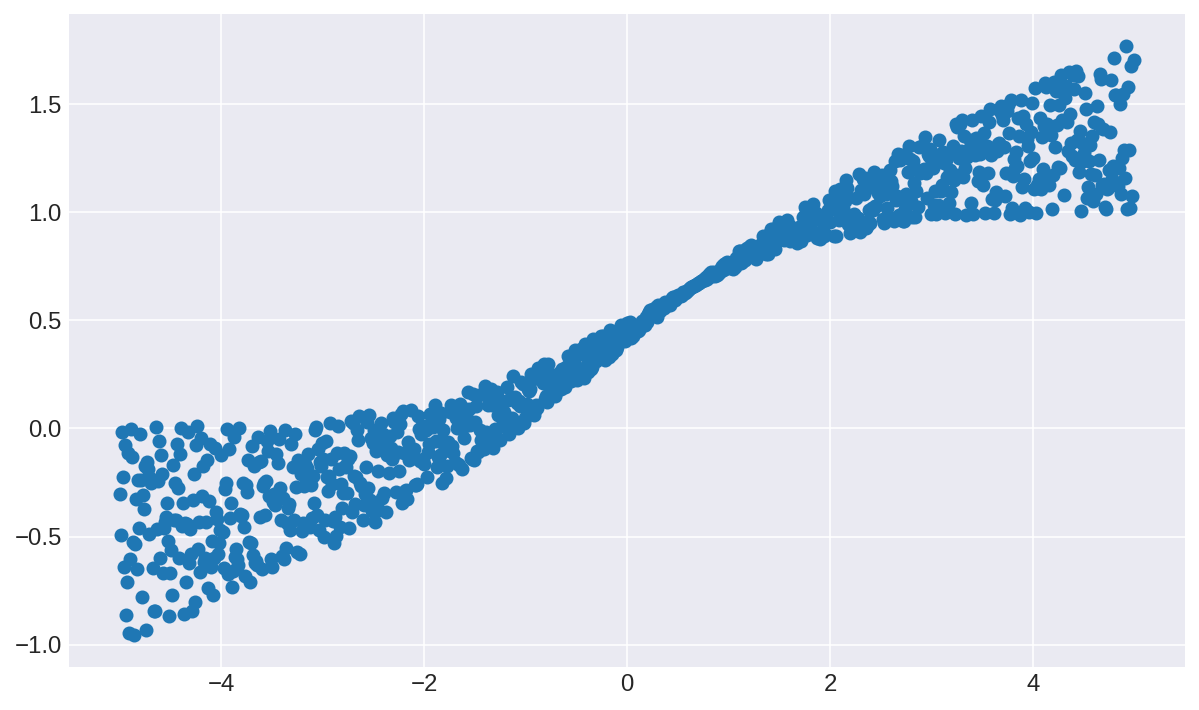

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(X, Y)
plt.show()

In [9]:
# 2. neural network
print( "Building neural network...")

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = [2, 5]
interval = 20

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)

Building neural network...


In [12]:
with pm.Model() as neural_network:

    step_size = pm.HalfNormal('step_size', sd=np.ones(n_hidden[0]), shape=n_hidden[0])

    # Weights from input to hidden layer
    weights_1 = pm.GaussianRandomWalk('layer1', sd=step_size,
                                    shape=(interval, X.shape[1], n_hidden[0]),
                                    testval=np.tile(init_1, (interval, 1, 1)))
    weights_1_rep = tt.repeat(weights_1, ann_input.shape[0] // interval, axis=0)

    weights_2 = pm.Normal('layer2', mu=0, sd=1.,
                        shape=(1, n_hidden[0], n_hidden[1]),
                        testval=init_2)
    weights_2_rep = tt.repeat(weights_2, ann_input.shape[0], axis=0)

    weights_out = pm.Normal('layer_out', mu=0, sd=1.,
                          shape=(1, n_hidden[1]),
                          testval=init_out)
    weights_out_rep = tt.repeat(weights_out, ann_input.shape[0], axis=0)

    intercept = pm.Normal('intercept', mu=0, sd=10.)

    # Now assemble the neural network
    layer_1 = tt.tanh(tt.batched_dot(ann_input, weights_1_rep))
    layer_2 = tt.tanh(tt.batched_dot(layer_1, weights_2_rep))
    layer_out = tt.batched_dot(layer_2, weights_out_rep)

    y = pm.Normal('y', mu=layer_out + intercept, sd=0.1, observed=ann_output)

In [14]:
num_samples = 1000
with neural_network:
    #trace = pm.sample(num_samples, tune=num_samples, nuts_kwargs=dict(target_accept=0.98, max_treedepth=15))
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = -1,302.3: 100%|██████████| 50000/50000 [01:07<00:00, 740.66it/s] 
Finished [100%]: Average Loss = -1,302.2


In [16]:
with neural_network:
    trace = approx.sample(draws=1000)

INFO (theano.gof.compilelock): Refreshing lock /home/rosgori/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock


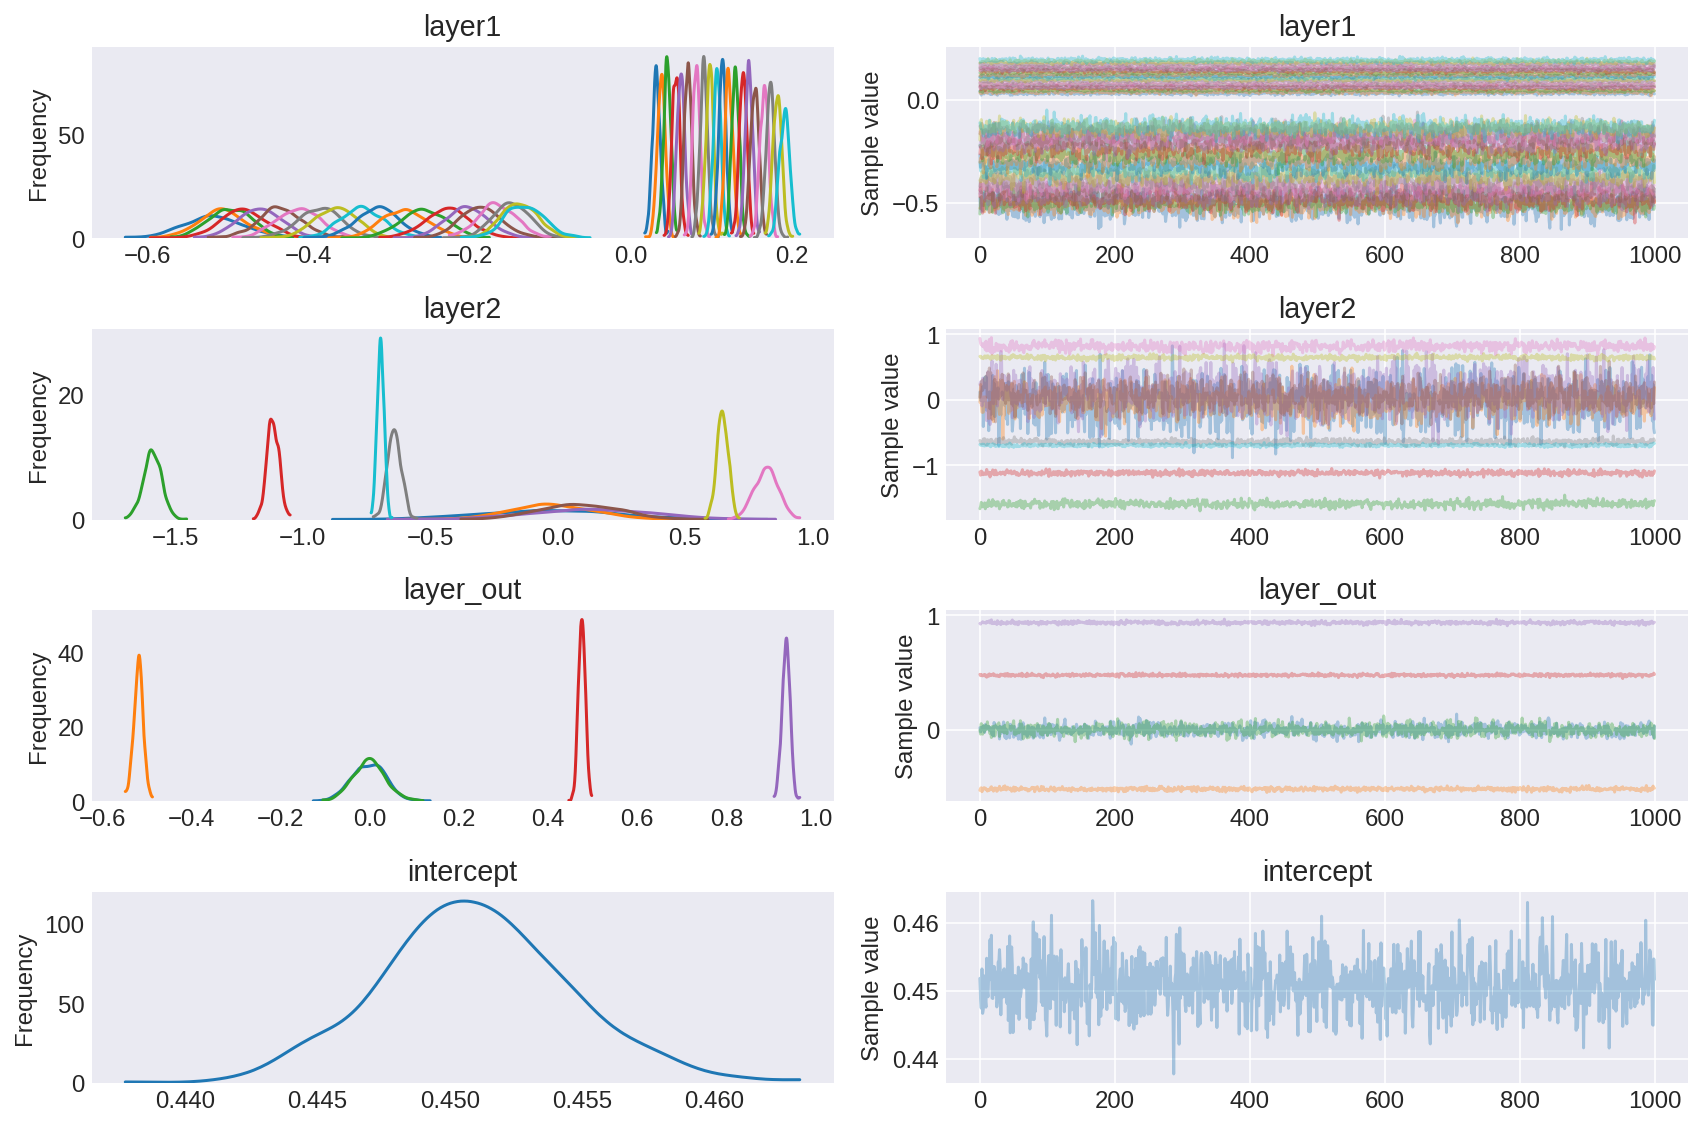

In [17]:
pm.traceplot(trace, ['layer1', 'layer2', 'layer_out', 'intercept']);

In [18]:
samples = pm.sample_ppc(trace, model=neural_network, size=100)
y_preds = samples['y']
print( "y_preds shape = ", y_preds.shape)

# get the average, since we're interested in plotting the expectation.
y_preds = np.mean(y_preds, axis=1)
y_preds = np.mean(y_preds, axis=0)

RMSD = np.sqrt(np.mean((y_preds - Y) ** 2.0))
RMSD

100%|██████████| 1000/1000 [00:25<00:00, 39.04it/s]


y_preds shape =  (1000, 100, 1000)


0.032322285789071654

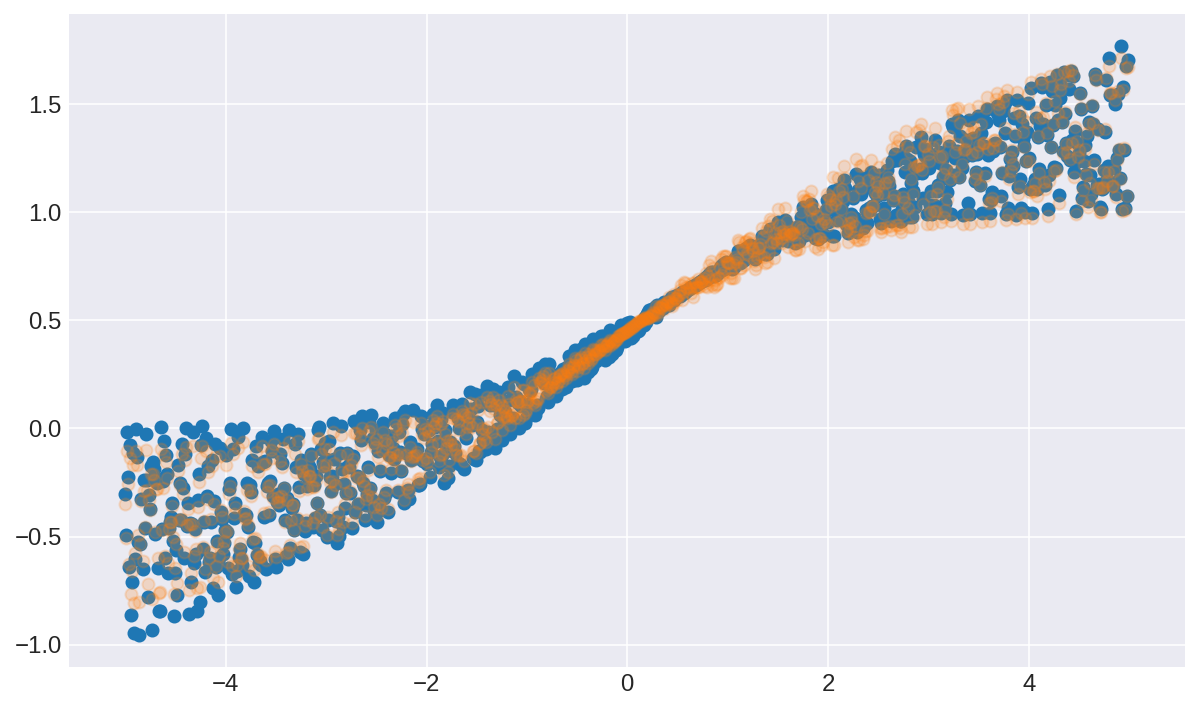

In [23]:
plt.figure(figsize=(10,6 ))
plt.scatter(X, Y)
plt.scatter(X, y_preds, alpha=0.2)
plt.show()

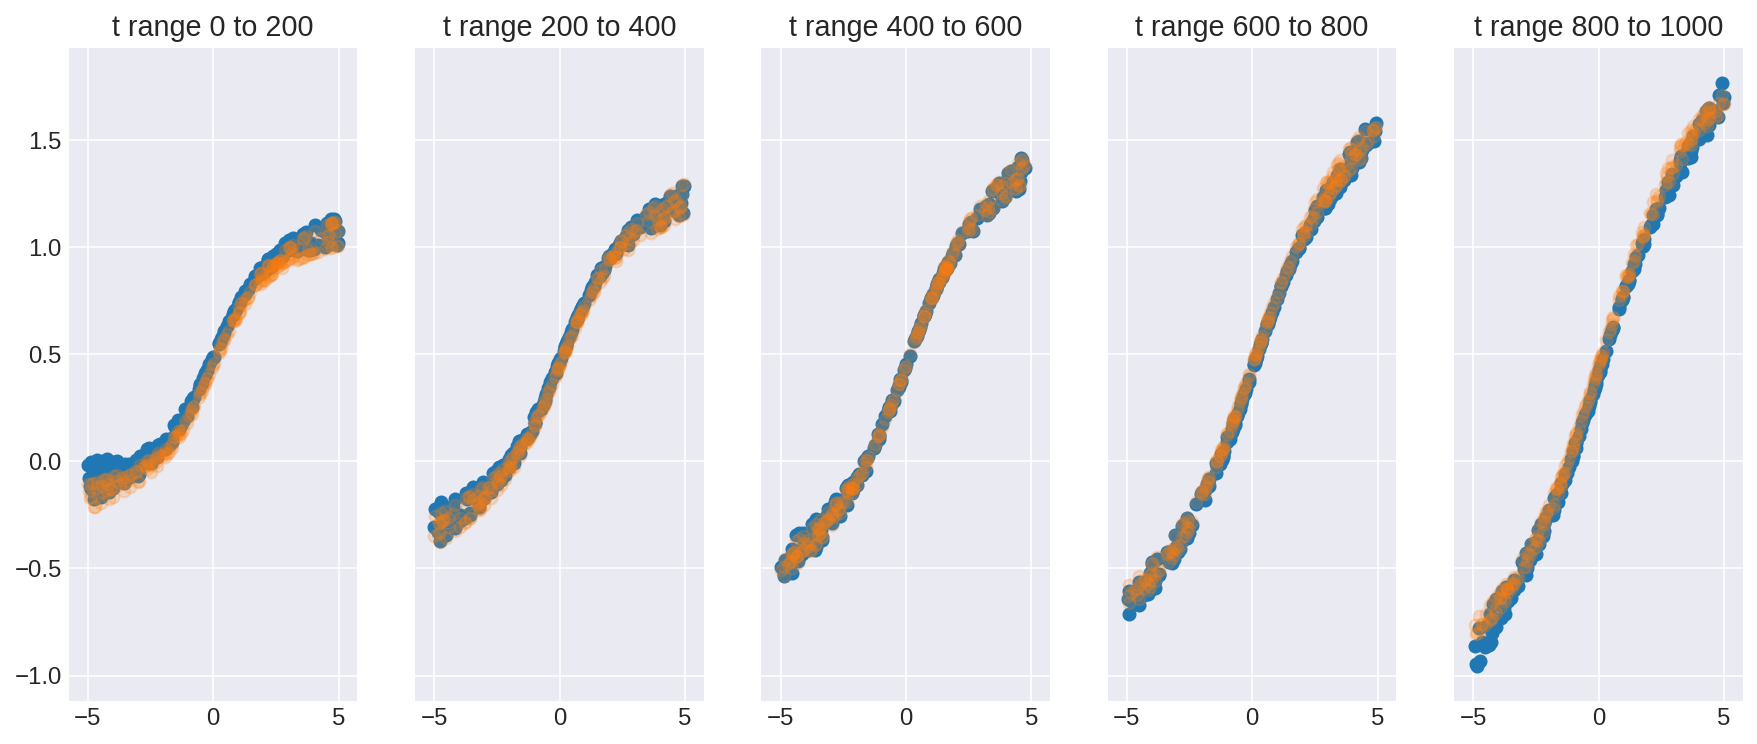

In [24]:
# show the time-varying effect
fig, axarr = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(15,6))

for i in range(len(axarr)):
    from_idx = 200 * i
    to_idx = 200 * (i + 1)

    axarr[i].scatter(X[from_idx:to_idx], Y[from_idx:to_idx])
    axarr[i].scatter(X[from_idx:to_idx], y_preds[from_idx:to_idx], alpha=0.2)
    axarr[i].set_title("t range %s to %s" % (from_idx, to_idx))

plt.show()